<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101175
Name = 'Mohammad Armin'
Last_Name = 'Dehghan'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

In [2]:
%pip install torch torchvision torchaudio
%pip install torchinfo


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [3]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [5]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

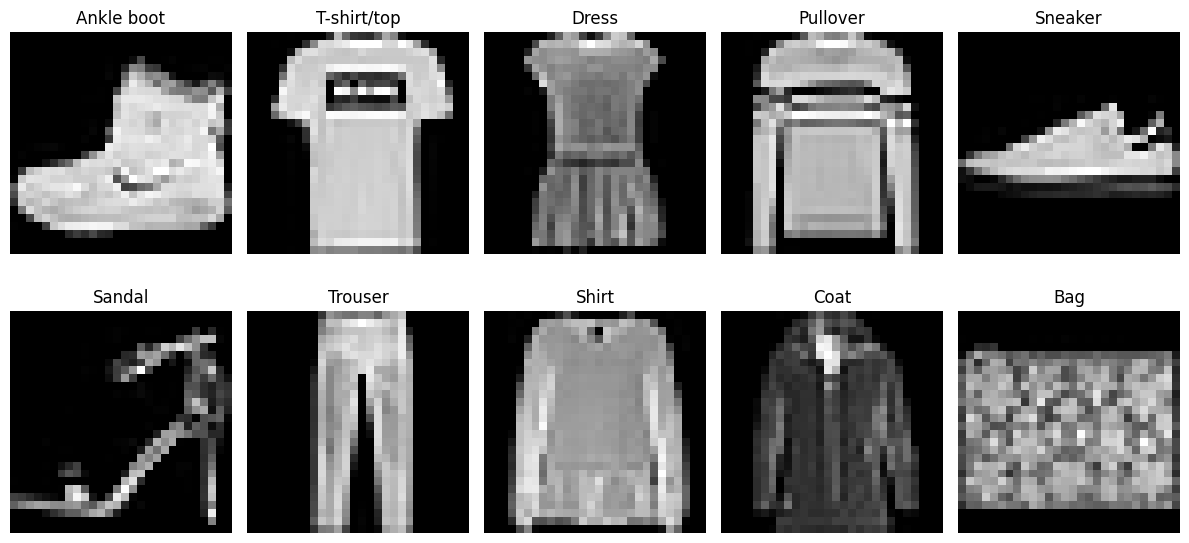

In [6]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
instances = {}

for img, label in dataset:
    if label not in instances:
        instances[label] = img
    if len(instances) == len(class_labels):
        break

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for idx, (label, img) in enumerate(instances.items()):
    img = img.squeeze() 
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(class_labels[label])
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset. 

In [7]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [8]:
######################
#   YOUR CODE HERE   #
######################
val_frac =  0.2
rand_seed =  40

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

In [9]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [10]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 64

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

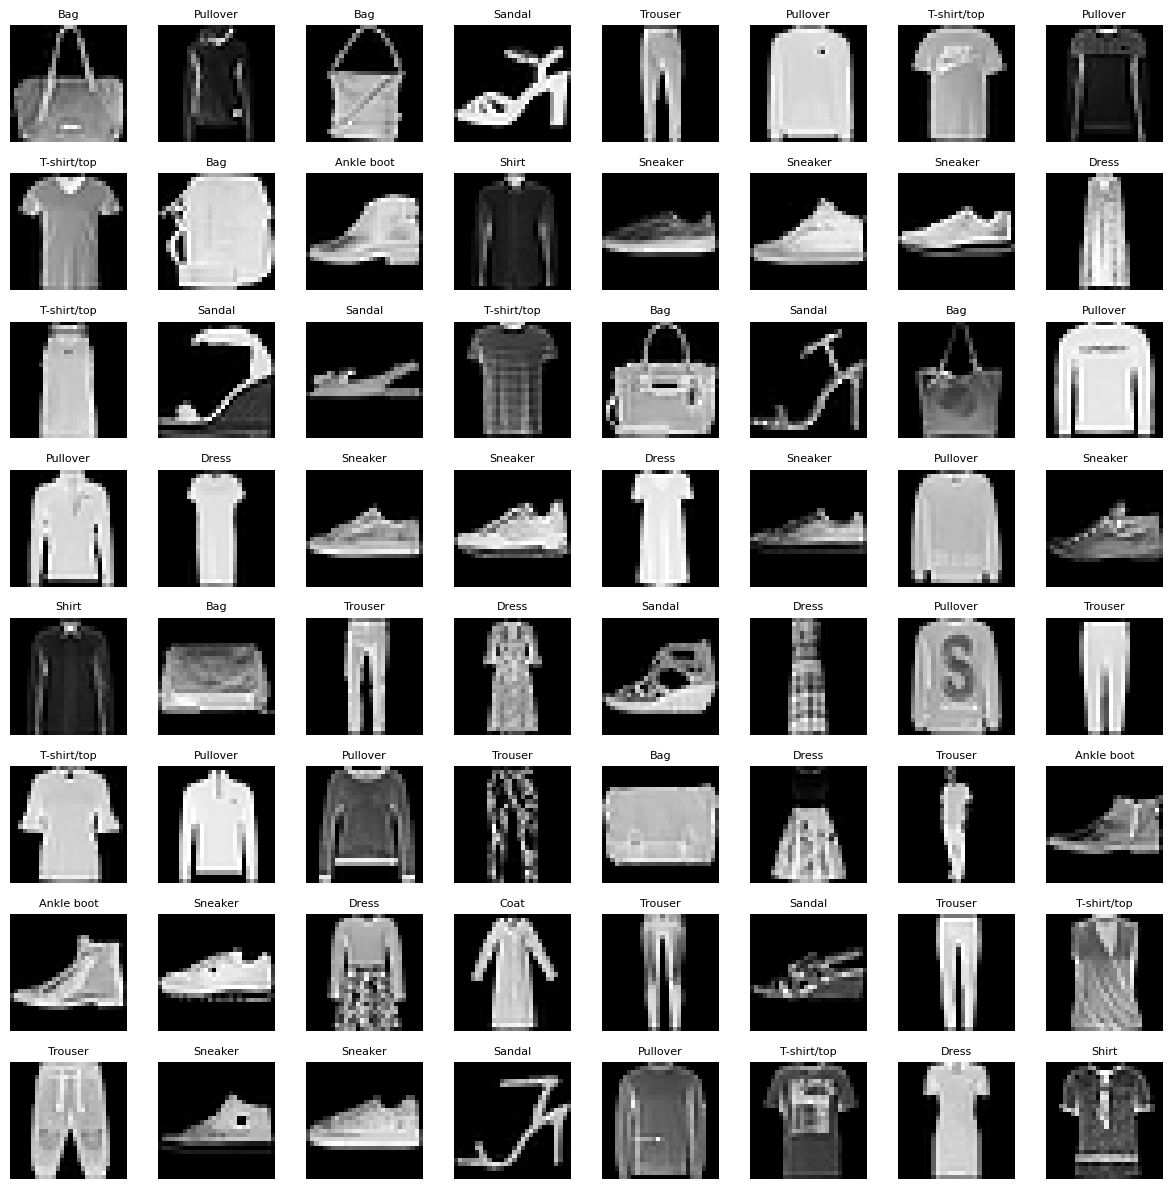

In [11]:
import matplotlib.pyplot as plt

# Function to unnormalize and plot images
def imshow(img, ax):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    ax.imshow(npimg, cmap='gray')
    ax.axis('off')

# Get a batch of training data
dataiter = iter(train_dl)
images, labels = next(dataiter)

# Class labels for FashionMNIST
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Plot the images in the batch with their corresponding labels
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()

for idx in range(batch_size):
    img = images[idx].squeeze() / 2 + 0.5  
    npimg = img.numpy()
    axes[idx].imshow(npimg, cmap='gray')  
    axes[idx].set_title(class_labels[labels[idx].item()], fontsize=8)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [12]:
# Import required packages
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):  
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #
        ######################
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes for classification

    def forward(self, X):
        ######################
        #   YOUR CODE HERE   #
        ######################
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = X.view(-1, 64 * 3 * 3)  
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X


In [14]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [15]:
summary(model, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Conv2d: 1-5                            [64, 64, 7, 7]            18,496
├─MaxPool2d: 1-6                         [64, 64, 3, 3]            --
├─Linear: 1-7                            [64, 128]                 73,856
├─Linear: 1-8                            [64, 10]                  1,290
Total params: 98,442
Trainable params: 98,442
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 129.05
Input size (MB): 0.20
Forward/backward pass size (MB): 11.31
Params size (MB): 0.39
Estimated Total Size (MB): 11.90

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [16]:
import torch.optim as optim
import torch



def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader (can be None or empty)
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Initialize the optimizer
    optimizer = opt_fn(model.parameters(), lr=lr)
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(n_epochs):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for data in train_dl:
            inputs, labels = data
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_dl)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        
        if val_dl:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for data in val_dl:
                    inputs, labels = data
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_loss = val_loss / len(val_dl)
            val_accuracy = 100 * correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            print(f'Epoch {epoch+1}/{n_epochs}, '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        else:
            print(f'Epoch {epoch+1}/{n_epochs}, '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies



In [17]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 10  # Number of training epochs
loss_fn = nn.CrossEntropyLoss()  # Define the loss function
opt_fn = optim.Adam  # Select an optimizer
lr = 0.001  # Set the learning rate

In [18]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.5665, Train Accuracy: 79.33%, Val Loss: 0.3891, Val Accuracy: 85.62%
Epoch 2/10, Train Loss: 0.3451, Train Accuracy: 87.42%, Val Loss: 0.3187, Val Accuracy: 88.48%
Epoch 3/10, Train Loss: 0.2932, Train Accuracy: 89.26%, Val Loss: 0.2828, Val Accuracy: 89.74%
Epoch 4/10, Train Loss: 0.2594, Train Accuracy: 90.50%, Val Loss: 0.2789, Val Accuracy: 90.20%
Epoch 5/10, Train Loss: 0.2345, Train Accuracy: 91.42%, Val Loss: 0.2508, Val Accuracy: 90.95%
Epoch 6/10, Train Loss: 0.2155, Train Accuracy: 92.09%, Val Loss: 0.2659, Val Accuracy: 90.42%
Epoch 7/10, Train Loss: 0.1992, Train Accuracy: 92.55%, Val Loss: 0.2445, Val Accuracy: 91.05%
Epoch 8/10, Train Loss: 0.1814, Train Accuracy: 93.21%, Val Loss: 0.2390, Val Accuracy: 91.39%
Epoch 9/10, Train Loss: 0.1697, Train Accuracy: 93.61%, Val Loss: 0.2408, Val Accuracy: 91.51%
Epoch 10/10, Train Loss: 0.1569, Train Accuracy: 94.12%, Val Loss: 0.2261, Val Accuracy: 91.73%


### Plot loss and accuracy

In [19]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

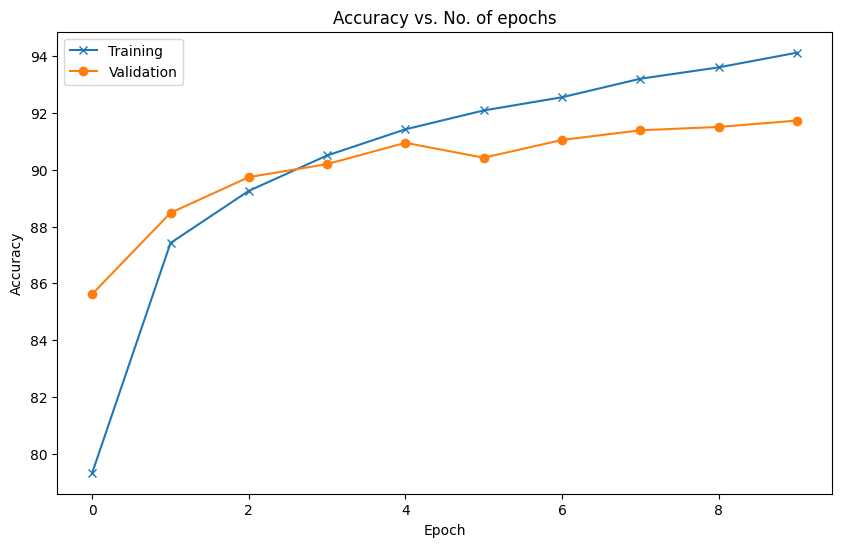

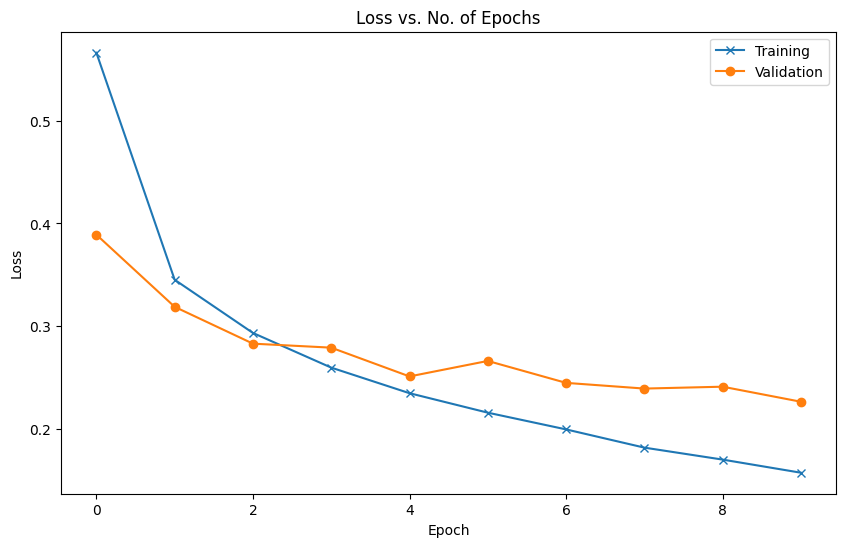

In [20]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [21]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [22]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 10
lr = 0.001

In [23]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.1667, Train Accuracy: 93.88%
Epoch 2/10, Train Loss: 0.1517, Train Accuracy: 94.48%
Epoch 3/10, Train Loss: 0.1391, Train Accuracy: 94.80%
Epoch 4/10, Train Loss: 0.1301, Train Accuracy: 95.13%
Epoch 5/10, Train Loss: 0.1191, Train Accuracy: 95.53%
Epoch 6/10, Train Loss: 0.1114, Train Accuracy: 95.75%
Epoch 7/10, Train Loss: 0.1004, Train Accuracy: 96.24%
Epoch 8/10, Train Loss: 0.0935, Train Accuracy: 96.48%
Epoch 9/10, Train Loss: 0.0853, Train Accuracy: 96.77%
Epoch 10/10, Train Loss: 0.0805, Train Accuracy: 96.92%


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

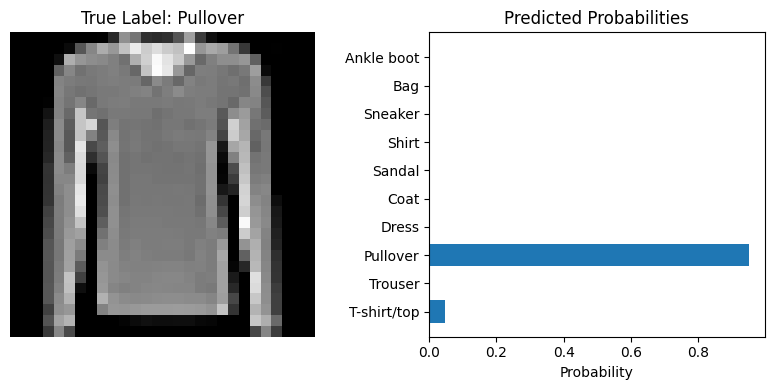

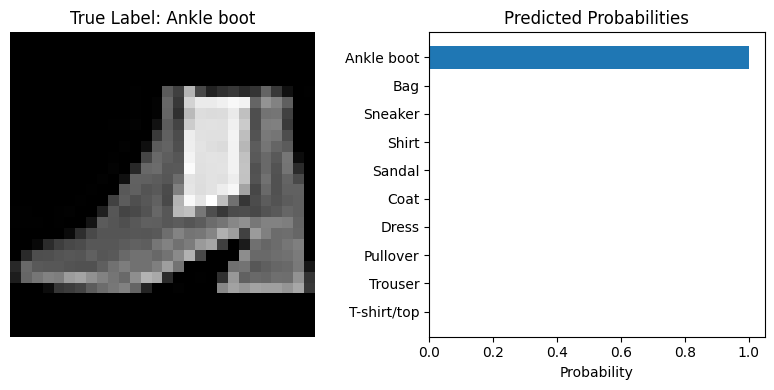

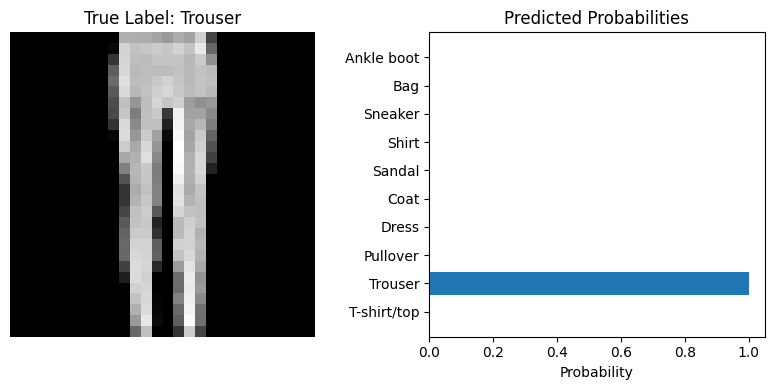

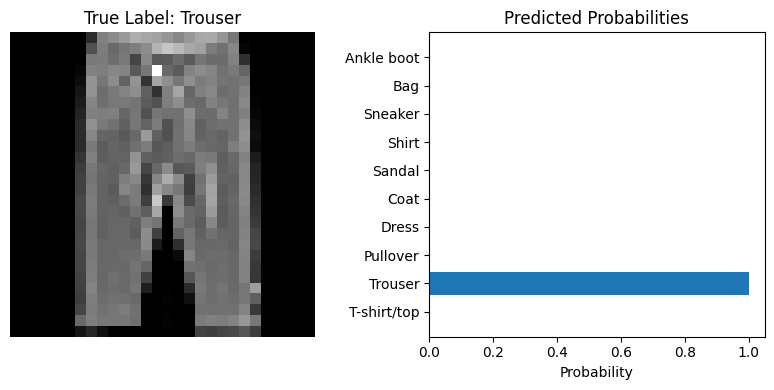

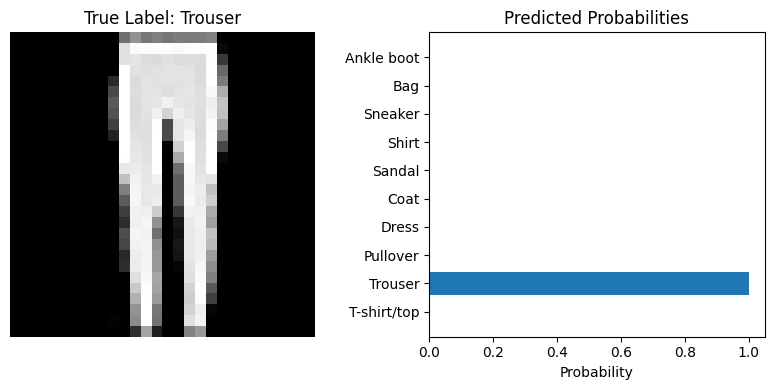

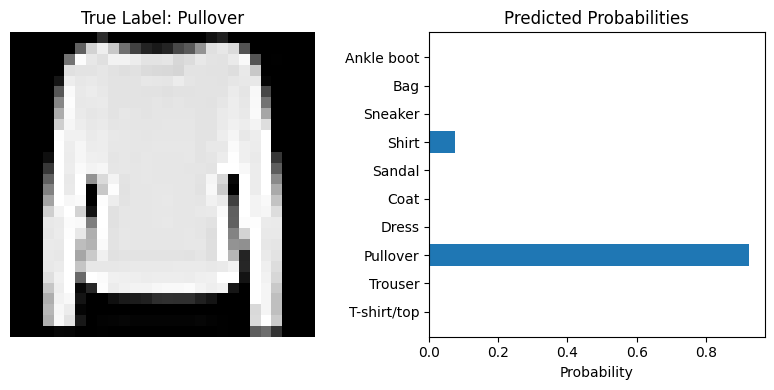

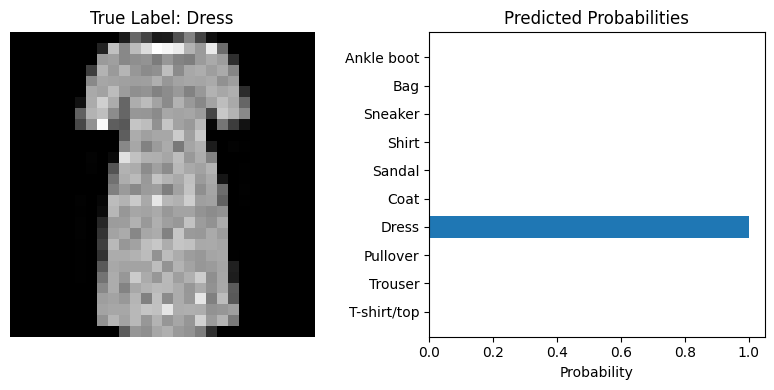

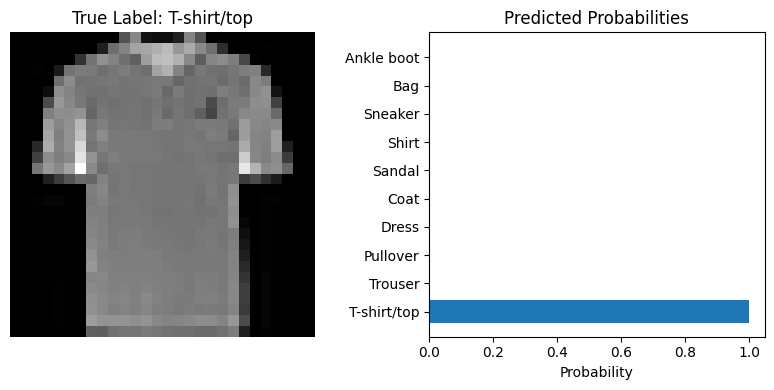

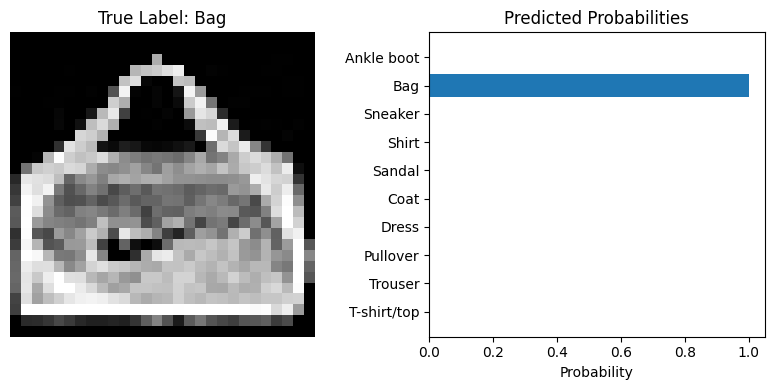

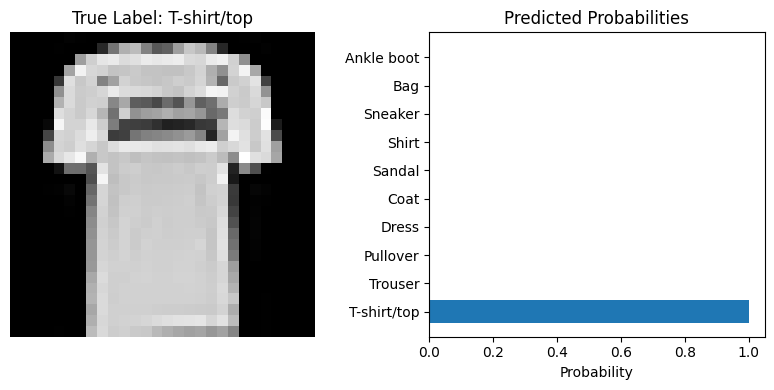

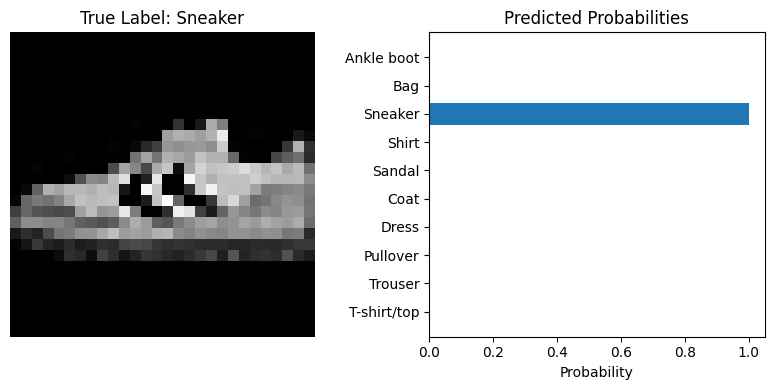

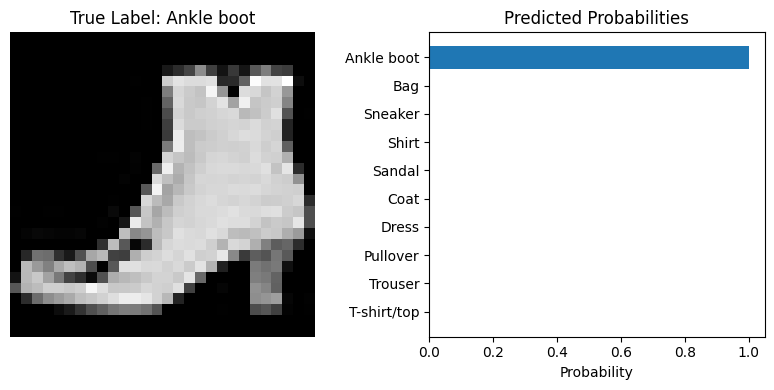

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def view_prediction(img, label, probs, class_names):
    """
    Visualizes the image along with its predicted probabilities.
    
    Args:
        img: The image tensor
        label: The true label
        probs: The predicted probabilities
        class_names: List of class names
    """
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))  
    ax1.imshow(npimg, cmap='gray')
    ax1.set_title(f'True Label: {class_names[label]}')
    ax1.axis('off')
    
    y_pos = np.arange(len(class_names))
    
    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(class_names)
    ax2.set_xlabel('Probability')
    ax2.set_title('Predicted Probabilities')
    
    plt.tight_layout()
    plt.show()

# Class labels for FashionMNIST
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def evaluate_model(model, dataloader, class_names, num_images=12):
    """
    Evaluates the model on the dataset and visualizes predictions.
    
    Args:
        model: The trained model
        dataloader: The data loader
        class_names: List of class names
        num_images: Number of images to display
    """
    model.eval()
    images, labels = next(iter(dataloader))
    
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
    
    for i in range(num_images):  
        img = images[i]
        label = labels[i].item()
        probs = probabilities[i].numpy()
        view_prediction(img, label, probs, class_names)

# Example usage
evaluate_model(model, val_dl, list(class_labels.values()), num_images=12)


### Save the model

In [25]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [26]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [27]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.
    
    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader
    
    Returns: 
        Test accuracy.
    """
    model.eval()  
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for data in test_dl:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy


In [28]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 91.0200
